## Examen Parcial - CC531 Analisis en Macrodatos

Estudiantes:
- Jose Caycho Villalobos
- Gustavo Lozano Acuña

## Hadoop Cluster Deployment

In ths occasion we are going to deploy a high availability hadoop cluster, the following figure shows the components of it:  

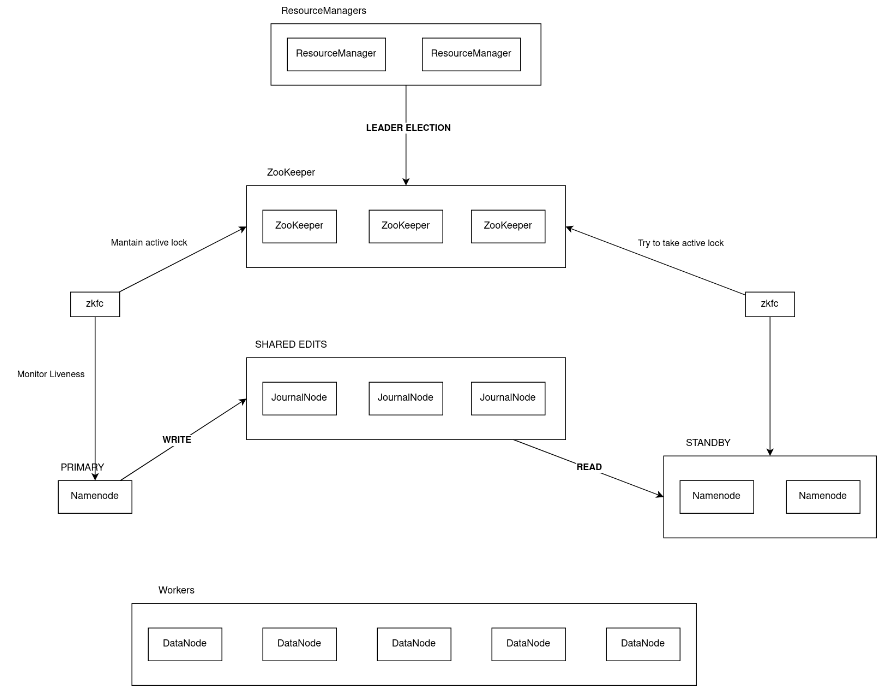

`scripts`: https://gitlab.com/college_works/cc531/hadoop-the-hard-way

## Cluster Inventory

For that we are going to use **10 nodes** organized of the following form:

In [3]:
! ls inventory/

groups.yml	  kerberos.yml	 namenodes.yml	       workers.yml
journalnodes.yml  mapreduce.yml  resourcemanagers.yml  zookeepers.yml


In [4]:
! cat inventory/namenodes.yml

# Definition of namenodes
#
# default value for 'namenode_id' variable: nn[i], where i in range(1, NUMBER_NAMENODES+1)
#
# Assignation of index i on namenode_id variable
# primary namenode   <> i = 1
# standby namenodes  <> i in range(2, NUMBER_STANDBY_NAMENODES+1)
# observer namenodes <> i in range(2 + NUMBER_STANDBY_NAMENODES, NUMBER_NAMENODES+1)

primary_namenode:
  hosts:
    localnode01.hadoopuni.com:

standby_namenodes:
  hosts: # definition of active and standby namenodes
    localnode[03:05:2].hadoopuni.com: # localnode03.hadoopuni.com, localnode05.hadoopuni.com

# https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-hdfs/ObserverNameNode.html
# observer_namenodes:
#   hosts: 
#     localnode[06:08].hadoopuni.com: # localnode06.hadoopuni.com, localnode07.hadoopuni.com, localnode08.hadoopuni.com

namenodes:
  children:
    primary_namenode:
    standby_namenodes:

#observer_namenodes:


In [5]:
! cat inventory/resourcemanagers.yml

# Definition of resourcemanagers
#
# default value for 'resourcemanager_id' variable: rm[i], where i in range(1, NUMBER_RESOURCEMANAGERS+1)

resourcemanagers:
  hosts:
    localnode[02:04:2].hadoopuni.com:


In [6]:
! cat inventory/workers.yml

# Definition of worker nodes (datanodes + nodemanagers)

workers:
  hosts:
    localnode[01:10].hadoopuni.com:

datanodes:
  children:
    workers:

nodemanagers:
  children:
    workers:


In [8]:
! cat inventory/mapreduce.yml

# Definition of MapReduce nodes

historyserver:
  hosts:
    localnode03.hadoopuni.com:


In [9]:
! cat inventory/journalnodes.yml

journalnodes:
  hosts:
    localnode[01:03].hadoopuni.com:


In [10]:
! cat inventory/zookeepers.yml

# Definition of zookeepers

zookeepers:
  hosts:
    zk01.hadoopuni.com:
    #zk[01:03].hadoopuni.com:


In [14]:
! cat inventory/groups.yml

# Definition of groups
hdfs:
  children:
    namenodes:
    datanodes:
    journalnodes:

yarn:
  children:
    resourcemanagers:
    nodemanagers:

hadoop:
  children:
    hdfs:
    yarn:


### Generating namenode_id and resourcemanager_id for our namenodes and resourcemanagers nodes

In [11]:
!python3 utils/hadoop/inventory/generate_node_identifier.py -i inventory/

[WARNING]: Could not match supplied host pattern, ignoring: observer_namenodes
Adding variable: namenode_id, value: nn01 to inventory/host_vars/localnode01.hadoopuni.com.yml
Adding variable: namenode_id, value: nn02 to inventory/host_vars/localnode03.hadoopuni.com.yml
Adding variable: namenode_id, value: nn03 to inventory/host_vars/localnode05.hadoopuni.com.yml
Adding variable: resourcemanager_id, value: rm01 to inventory/host_vars/localnode02.hadoopuni.com.yml
Adding variable: resourcemanager_id, value: rm02 to inventory/host_vars/localnode04.hadoopuni.com.yml


### Prepare hadoop nodes with hadoop image

In [17]:
! ansible-playbook --private-key example.pem -b -u vagrant -i inventory/ images/playbooks/hadoop.yml


PLAY [hadoop] ******************************************************************

TASK [Gathering Facts] *********************************************************
ok: [localnode01.hadoopuni.com]
ok: [localnode05.hadoopuni.com]
ok: [localnode04.hadoopuni.com]
ok: [localnode03.hadoopuni.com]
ok: [localnode02.hadoopuni.com]
fatal: [localnode10.hadoopuni.com]: UNREACHABLE! => {"changed": false, "msg": "Failed to connect to the host via ssh: ssh: connect to host localnode10.hadoopuni.com port 22: No route to host", "unreachable": true}
ok: [localnode06.hadoopuni.com]
ok: [localnode07.hadoopuni.com]
ok: [localnode09.hadoopuni.com]
ok: [localnode08.hadoopuni.com]

TASK [../roles/hadoop : debug] *************************************************
ok: [localnode01.hadoopuni.com] => {
    "ansible_os_family": "Debian"
}
ok: [localnode02.hadoopuni.com] => {
    "ansible_os_family": "Debian"
}
ok: [localnode03.hadoopuni.com] => {
    "ansible_os_family": "Debian"
}
ok: [localnode04.hadoopuni.com] =

### Prepare zookeeper nodes with zookeeper image

In [18]:
! ansible-playbook --private-key example.pem -b -u vagrant -i inventory/ images/playbooks/zookeeper.yml


PLAY [zookeepers] **************************************************************

TASK [Gathering Facts] *********************************************************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : include_tasks] **************************************
included: /home/glozanoa/classes/20232/uni/macro/parcial/hadoop-the-hard-way/images/roles/zookeeper/tasks/debug.yml for zk01.hadoopuni.com

TASK [../roles/zookeeper : debug] **********************************************
ok: [zk01.hadoopuni.com] => {
    "ansible_os_family": "Debian"
}

TASK [../roles/zookeeper : debug] **********************************************
ok: [zk01.hadoopuni.com] => {
    "java.version": "11"
}

TASK [../roles/zookeeper : debug] **********************************************
ok: [zk01.hadoopuni.com] => {
    "zookeeper": {
        "checksum": "",
        "conf": "/etc/zookeeper.conf",
        "data_dir": "/var/zookeeper",
        "home": "/opt/apache-zookeeper-3.9.1-bin",
        "log_dir": "

### Configure hadoop (hdfs and yarn)

In [12]:
# configuration variables for hadoop cluster
! cat vars/test/configure.yml

hadoop_home: "/opt/hadoop-3.3.6"

## YARN
yarn_cluster_id: "yarncluster"
nodemanager_local_dirs: "/opt/nodemanager_local"
nodemanager_log_dirs: "/opt/nodemanager_logs"

## HDFS
format_hdfs: true
bootstrap_standby: true
namenode_name_dir: "/opt/namenode"
datanode_data_dir: "/opt/datanode"

### HDFS - HA
format_zkfc: true
dfs_nameservices: "mycluster"
dfs_ha_fencing_method: "sshfence"
hdfs_ha_fencing_private_key_pair: "/var/hadoop/.ssh/id_rsa"
journalnode_edits_dir: "/opt/jornalnode"
init_shared_edits: true

### HADOOP - Monitor



In [19]:
! ansible-playbook --private-key example.pem -b -u vagrant -i inventory/ --extra-vars=@vars/test/configure.yml playbooks/hadoop.yml


PLAY [zookeepers] **************************************************************

TASK [Gathering Facts] *********************************************************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Create zookeeper data directory] ********************
changed: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Generate zookeeper configuration file] **************
changed: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Enable zookeeper service] ***************************
changed: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Start zookeeper service] ****************************
changed: [zk01.hadoopuni.com]

PLAY [journalnodes] ************************************************************

TASK [Gathering Facts] *********************************************************
ok: [localnode01.hadoopuni.com]
ok: [localnode02.hadoopuni.com]
ok: [localnode03.hadoopuni.com]

TASK [../roles/hadoop_common : Generate core-site.xml hadoop configuration file] ***
changed: [localno

### Configure zookeeper nodes for automatic failover

In [23]:
! ansible-playbook --private-key example.pem -b -u vagrant -i inventory/ playbooks/zookeeper.yml


PLAY [zookeepers] **************************************************************

TASK [Gathering Facts] *********************************************************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Create zookeeper data directory] ********************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Generate zookeeper configuration file] **************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Enable zookeeper service] ***************************
ok: [zk01.hadoopuni.com]

TASK [../roles/zookeeper : Start zookeeper service] ****************************
ok: [zk01.hadoopuni.com]

PLAY RECAP *********************************************************************
zk01.hadoopuni.com         : ok=5    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



### Testing deployed hadoop cluster

In [1]:
# Listing the namenodes
# reference: https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-hdfs/HDFSCommands.html#haadmin
! hdfs haadmin -getAllServiceState

localnode01.hadoopuni.com:8020                     standby   
localnode03.hadoopuni.com:8020                     standby   
localnode05.hadoopuni.com:8020                     active    


In [2]:
# Listing the resourcemanagers
# reference: https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YarnCommands.html#rmadmin
! yarn rmadmin -getAllServiceState

localnode02.hadoopuni.com:8033                     standby   
localnode04.hadoopuni.com:8033                     active    


In [4]:
# Listing the datanodes
! hdfs dfsadmin -report -live

Configured Capacity: 596313059328 (555.36 GB)
Present Capacity: 494877495296 (460.89 GB)
DFS Remaining: 494877212672 (460.89 GB)
DFS Used: 282624 (276 KB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (9):

Name: 192.168.56.10:9866 (localnode01.hadoopuni.com)
Hostname: localnode01
Decommission Status : Normal
Configured Capacity: 66257006592 (61.71 GB)
DFS Used: 36864 (36 KB)
Non DFS Used: 7753076736 (7.22 GB)
DFS Remaining: 55105040384 (51.32 GB)
DFS Used%: 0.00%
DFS Remaining%: 83.17%
Configured Cache Ca

In [5]:
# Uploading a file to hdfs
! hdfs dfs -put README.org /
! hdfs dfs -ls /

Found 1 items
-rw-r--r--   3 root supergroup       3628 2023-10-18 18:40 /README.org


### Testing high availability and automatic failover of hadoop cluster

#### active namenode failover

In [16]:
! hdfs haadmin -getAllServiceState

localnode01.hadoopuni.com:8020                     standby   
localnode03.hadoopuni.com:8020                     active    
localnode05.hadoopuni.com:8020                     standby   


In [17]:
! ansible-playbook --limit localnode03.hadoopuni.com --private-key example.pem -b -u vagrant -i inventory/ playbooks/utils/hdfs/services/stop_namenodes.yml


PLAY [namenodes] ***************************************************************

TASK [Gathering Facts] *********************************************************
ok: [localnode03.hadoopuni.com]

TASK [Stop namenode service] ***************************************************
changed: [localnode03.hadoopuni.com]

PLAY RECAP *********************************************************************
localnode03.hadoopuni.com  : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [19]:
! hdfs haadmin -getAllServiceState

localnode01.hadoopuni.com:8020                     standby   
2023-10-18 19:01:44,414 INFO ipc.Client: Retrying connect to server: localnode03.hadoopuni.com/192.168.56.12:8020. Already tried 0 time(s); retry policy is RetryUpToMaximumCountWithFixedSleep(maxRetries=1, sleepTime=1000 MILLISECONDS)
localnode03.hadoopuni.com:8020                     Failed to connect: Call From localnode07/127.0.2.1 to localnode03.hadoopuni.com:8020 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
localnode05.hadoopuni.com:8020                     standby   


In [20]:
! ansible-playbook --limit localnode05.hadoopuni.com --private-key example.pem -b -u vagrant -i inventory/ playbooks/utils/hdfs/services/start_namenodes.yml


PLAY [namenodes] ***************************************************************

TASK [Gathering Facts] *********************************************************
ok: [localnode05.hadoopuni.com]

TASK [Start namenode service] **************************************************
ok: [localnode05.hadoopuni.com]

PLAY RECAP *********************************************************************
localnode05.hadoopuni.com  : ok=2    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [29]:
! hdfs haadmin -getAllServiceState

localnode01.hadoopuni.com:8020                     standby   
2023-10-18 19:07:07,868 INFO ipc.Client: Retrying connect to server: localnode03.hadoopuni.com/192.168.56.12:8020. Already tried 0 time(s); retry policy is RetryUpToMaximumCountWithFixedSleep(maxRetries=1, sleepTime=1000 MILLISECONDS)
localnode03.hadoopuni.com:8020                     Failed to connect: Call From localnode07/127.0.2.1 to localnode03.hadoopuni.com:8020 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
localnode05.hadoopuni.com:8020                     standby   


In [30]:
! hdfs haadmin -transitionToActive  nn01 

Automatic failover is enabled for NameNode at localnode03.hadoopuni.com/192.168.56.12:8020
Refusing to manually manage HA state, since it may cause
a split-brain scenario or other incorrect state.
If you are very sure you know what you are doing, please 
specify the --forcemanual flag.


In [31]:
! hdfs haadmin -transitionToActive --forcemanual  nn01 

You have specified the --forcemanual flag. This flag is dangerous, as it can induce a split-brain scenario that WILL CORRUPT your HDFS namespace, possibly irrecoverably.

It is recommended not to use this flag, but instead to shut down the cluster and disable automatic failover if you prefer to manually manage your HA state.

You may abort safely by answering 'n' or hitting ^C now.

Are you sure you want to continue? (Y or N) ^C
Invalid input: 
You have specified the --forcemanual flag. This flag is dangerous, as it can induce a split-brain scenario that WILL CORRUPT your HDFS namespace, possibly irrecoverably.

It is recommended not to use this flag, but instead to shut down the cluster and disable automatic failover if you prefer to manually manage your HA state.

You may abort safely by answering 'n' or hitting ^C now.

Are you sure you want to continue? (Y or N) 

In [32]:
! hdfs haadmin -getAllServiceState

localnode01.hadoopuni.com:8020                     standby   
2023-10-18 19:08:32,949 INFO ipc.Client: Retrying connect to server: localnode03.hadoopuni.com/192.168.56.12:8020. Already tried 0 time(s); retry policy is RetryUpToMaximumCountWithFixedSleep(maxRetries=1, sleepTime=1000 MILLISECONDS)
localnode03.hadoopuni.com:8020                     Failed to connect: Call From localnode07/127.0.2.1 to localnode03.hadoopuni.com:8020 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
localnode05.hadoopuni.com:8020                     standby   


#### active resourcemanager failover

In [26]:
! yarn rmadmin -getAllServiceState

localnode02.hadoopuni.com:8033                     standby   
localnode04.hadoopuni.com:8033                     active    


In [ ]:
! ansible-playbook --limit localnode04.hadoopuni.com --private-key example.pem -b -u vagrant -i inventory/ playbooks/utils/hdfs/services/stop_resourcemanagers.yml

In [ ]:
! yarn rmadmin -getAllServiceState

## Multi MapReduce

### Dataset

In [25]:
# downloading dataset
# source: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store

#!gdown 1fgRumFcLa4lNOnaRiOua-CK51884A0CF

In [2]:
import pandas as pd

# location: world_food_facts/input/
DATASET_FILE_NAME='examples/mapreduce/ecommerce_behavior/input/2019-Nov_0-25.csv'

data = pd.read_csv(DATASET_FILE_NAME)
print(f"data.shape: {data.shape}")
data.head()

data.shape: (24, 9)


event_time event_type  product_id          category_id  \
0  2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1  2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2  2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3  2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4  2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   

               category_code   brand   price    user_id  \
0     electronics.smartphone  xiaomi  489.07  520088904   
1  appliances.sewing_machine  janome  293.65  530496790   
2                        NaN   creed   28.31  561587266   
3  appliances.kitchen.washer      lg  712.87  518085591   
4     electronics.smartphone  xiaomi  183.27  558856683   

                           user_session  
0  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1  8e5f4f83-366c-4f70-860e-ca7417414283  
2  755422e7-9040-477b-9bd2-6a6e8fd97387  
3  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4  313628f1-68b8-460d-84f6-cec7a8796ef2

In [7]:
!ls examples/mapreduce/ecommerce_behavior/input/*.csv

examples/mapreduce/ecommerce_behavior/input/2019-Nov_0-25.csv
examples/mapreduce/ecommerce_behavior/input/2019-Oct_0-25.csv


In [14]:
!hdfs dfs -mkdir -p /input/ecommerce_behavior

In [16]:
! hdfs dfs -put examples/mapreduce/ecommerce_behavior/input/*.csv /input/ecommerce_behavior
! hdfs dfs -ls  /input/ecommerce_behavior

put: `/input/ecommerce_behavior/2019-Nov_0-25.csv': File exists
put: `/input/ecommerce_behavior/2019-Oct_0-25.csv': File exists
Found 14 items
-rw-r--r--   1 root root       3236 2023-10-18 21:28 /input/ecommerce_behavior/2019-Nov_0-25.csv
-rw-r--r--   1 root root       3364 2023-10-18 21:28 /input/ecommerce_behavior/2019-Oct_0-25.csv
-rw-r--r--   1 root root     123637 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009.csv
-rw-r--r--   1 root root       3240 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009_0-25.csv
-rw-r--r--   1 root root       1281 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009_prepared.csv
-rw-r--r--   1 root root       1601 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009_prepared_final.csv
-rw-r--r--   1 root root     123659 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009_purged.csv
-rw-r--r--   1 root root       1375 2023-10-18 21:26 /input/ecommerce_behavior/SalesJan2009_purged_0-10.csv
-rw-r--r--   1 root root       3057 202

### Query 1

#### Single MapReduce

## Query Analysis

`query`: Encuentra los productos electronics (by categoria) que fueron vistos durante[START, END] que superan el precio medio de su categoria.


### Custom datatypes
ProductWritable(product_id, category_id, category_code, brand, price)

ProductAccumulatorWritable
    accumulated: 0 (accumulated price sum)
    elements: (number of added elements)
    product: ProductWritable
    
## MapReduce Structure

### Single MapReduce
- Mapper (output=[**KEY** = "{category_code}", **VALUE** = {ProductWritable(product_id, category_id, category_code, brand, price)}])
    - class: `Mapper<LongWritable, Text, Text, ProductWritable>`
    - operation:
        - Parse CSV dataset and extract the components <`{event_time}`, `{event_type}`, `{product_id}`,  `{category_id}`, `{category_code}`, `{brand}`, `{price}`>
        - Filter the products based on the following criterias:
            - `event_time` in [START_TIME, END_TIME]
            - `event_type` == `view`
            - `category_code` in [electronics.smartphone.*, computers.*]
  
- Combiner (output=[**KEY** = "{category_code}", **VALUE** = {ProductAccumulatorWritable(accumulated, elements, product)}])
    - class: `Reducer<Text, ProductWritable, Text, ProductAccumulatorWritable>`
    - operation:
        - Aggregate product prices and count aggregated elements
          
- Reducer (output=[**KEY** = "{category_code}", **VALUE** = {ProductAccumulatorWritable(accumulated, elements, product)}])
    - class: `Reducer<Text, ProductWritable, Text, ProductAccumulatorWritable>`
    - operation:
        - Perform a global reduction of aggregated product (Generated by `Combiner`) 



#### Local Query

In [3]:
import pandas as pd

data = pd.read_csv(DATASET_FILE_NAME)
print(f"data.shape: {data.shape}")
data.head()

data.shape: (24, 9)


event_time event_type  product_id          category_id  \
0  2019-11-01 00:00:00 UTC       view     1003461  2053013555631882655   
1  2019-11-01 00:00:00 UTC       view     5000088  2053013566100866035   
2  2019-11-01 00:00:01 UTC       view    17302664  2053013553853497655   
3  2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
4  2019-11-01 00:00:01 UTC       view     1004775  2053013555631882655   

               category_code   brand   price    user_id  \
0     electronics.smartphone  xiaomi  489.07  520088904   
1  appliances.sewing_machine  janome  293.65  530496790   
2                        NaN   creed   28.31  561587266   
3  appliances.kitchen.washer      lg  712.87  518085591   
4     electronics.smartphone  xiaomi  183.27  558856683   

                           user_session  
0  4d3b30da-a5e4-49df-b1a8-ba5943f1dd33  
1  8e5f4f83-366c-4f70-860e-ca7417414283  
2  755422e7-9040-477b-9bd2-6a6e8fd97387  
3  3bfb58cd-7892-48cc-8020-2f17e6de6e7f  
4  313628f1-68b8-460d-84f6-cec7a8796ef2

#### MapReduce Query

In [17]:
! cd examples/mapreduce/ecommerce_behavior  && \
    hadoop jar build/libs/ecommerce_behavior-4.0.jar query1.single.MRDriver \
        /input/ecommerce_behavior/2019-Nov_0-25.csv /output/ecommerce_behavior/query1/single/out001

2023-10-18 21:29:02,742 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-10-18 21:29:02,822 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-10-18 21:29:02,822 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-10-18 21:29:02,924 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-10-18 21:29:03,112 INFO input.FileInputFormat: Total input files to process : 1
2023-10-18 21:29:03,147 INFO mapreduce.JobSubmitter: number of splits:1
2023-10-18 21:29:03,325 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1365602732_0001
2023-10-18 21:29:03,325 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-10-18 21:29:03,440 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2023-10-18 21:29:03,442 INFO mapreduce.Job: Running job: job_local1365602732_

2023-10-18 21:29:03,690 INFO mapred.LocalJobRunner: map
2023-10-18 21:29:03,690 INFO mapred.Task: Task 'attempt_local1365602732_0001_m_000000_0' done.
2023-10-18 21:29:03,697 INFO mapred.Task: Final Counters for attempt_local1365602732_0001_m_000000_0: Counters: 18
	File System Counters
		FILE: Number of bytes read=47020185
		FILE: Number of bytes written=48021229
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=25
		Map output records=5
		Map output bytes=484
		Map output materialized bytes=370
		Input split bytes=113
		Combine input records=5
		Combine output records=1
		Spilled Records=1
		Failed Shuffles=0
		Merged Map outputs=0
		GC time elapsed (ms)=0
		Total committed heap usage (bytes)=528482304
	File Input Format Counters 
		Bytes Read=3276
2023-10-18 21:29:03,697 INFO mapred.LocalJobRunner: Finishing task: attempt_local1365602732_0001_m_000000_0
2023-10-18 21:29:03,698 

In [20]:
!hdfs dfs -ls /output/ecommerce_behavior/query1/single/out001

Found 2 items
-rw-r--r--   1 root root          0 2023-10-18 21:29 /output/ecommerce_behavior/query1/single/out001/_SUCCESS
-rw-r--r--   1 root root        365 2023-10-18 21:29 /output/ecommerce_behavior/query1/single/out001/part-r-00000


In [21]:
!hdfs dfs -cat /output/ecommerce_behavior/query1/single/out001/part-r-00000

electronics.smartphone	ProductAccumulatorWritable(accumulated=1721.24, elements=5, products=[ProductWritable(product_id=1004258, category_id=2053013555631882655, category_code=electronics.smartphone, brand=apple, price=732.07), ProductWritable(product_id=1003461, category_id=2053013555631882655, category_code=electronics.smartphone, brand=xiaomi, price=489.07)])


#### Data Exploration

In [31]:
#data_nov = pd.read_csv('./input/2019-Nov_0-25.csv')
#print(f"data_nov.shape: {data_nov.shape}")
#data_nov.head()

In [ ]:
#data_nov.category_code.unique()

In [ ]:
#data_nov.event_type.unique()

In [ ]:
# indexes of used csv fields
#used_csv_fields = ['event_time', 'event_type',  'product_id', 'category_id', 'category_code', 'brand', 'price']
#data_nov.columns.get_indexer_for(used_csv_fields)

### Query 2

### Local Query

In [52]:
import pandas as pd

# location: world_food_facts/input/
DATASET_FILE_NAME='examples/mapreduce/ecommerce_behavior/input/2019-Oct_0-25.csv'

df_test = pd.read_csv(DATASET_FILE_NAME)
print(f"data.shape: {data.shape}")
df_test.head()

data.shape: (25, 163)


event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b87a-4708-9857-6336556b0fcc  
2  566511c2-e2e3-422b-b695-cf8e6e792ca8  
3  7c90fc70-0e80-4590-96f3-13c02c18c713  
4  c6bd7419-2748-4c56-95b4-8cec9ff8b80d

In [53]:
category_code = "shoes"
event_type = "view"
brand = "baden"

cond1 = df_test["category_code"].str.contains(category_code)
cond2 = df_test["event_type"] == event_type
cond3 = df_test["brand"] == brand

cols = ["event_type", "category_code", "brand", "price"]

df = df_test[cols][cond1 & cond2 & cond3]
df = df.groupby(by=cols).max().reset_index()
df

/usr/lib/python3/dist-packages/pandas/core/groupby/groupby.py:4317: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


event_type       category_code  brand   price
0       view  apparel.shoes.keds  baden  102.71

#### Single MapReduce

In [57]:
! cd examples/mapreduce/ecommerce_behavior && \
    hadoop jar build/libs/ecommerce_behavior-4.0.jar query2.single.MRDriver \
        /input/ecommerce_behavior/2019-Oct_0-25.csv /output/ecommerce_behavior/query2/single/out0010

2023-10-18 21:38:44,031 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-10-18 21:38:44,112 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-10-18 21:38:44,112 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-10-18 21:38:44,124 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-10-18 21:38:44,190 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-10-18 21:38:44,372 INFO mapred.FileInputFormat: Total input files to process : 1
2023-10-18 21:38:44,383 INFO mapreduce.JobSubmitter: number of splits:1
2023-10-18 21:38:44,509 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1593213849_0001
2023-10-18 21:38:44,509 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-10-18 21:38:44,615 INFO mapreduce.Job: The url to track the job:

2023-10-18 21:38:44,878 INFO mapred.LocalJobRunner: Finishing task: attempt_local1593213849_0001_r_000000_0
2023-10-18 21:38:44,878 INFO mapred.LocalJobRunner: reduce task executor complete.
2023-10-18 21:38:45,626 INFO mapreduce.Job: Job job_local1593213849_0001 running in uber mode : false
2023-10-18 21:38:45,628 INFO mapreduce.Job:  map 100% reduce 100%
2023-10-18 21:38:45,629 INFO mapreduce.Job: Job job_local1593213849_0001 completed successfully
2023-10-18 21:38:45,636 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=94040716
		FILE: Number of bytes written=96041671
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=25
		Map output records=1
		Map output bytes=34
		Map output materialized bytes=42
		Input split bytes=100
		Combine input records=1
		Combine output records=1
		Reduce input groups=1
		Reduce shuffle bytes=42
		Reduce input recor

In [58]:
!hdfs dfs -ls /output/ecommerce_behavior/query2/single/out0010

Found 2 items
-rw-r--r--   1 root root          0 2023-10-18 21:38 /output/ecommerce_behavior/query2/single/out0010/_SUCCESS
-rw-r--r--   1 root root         85 2023-10-18 21:38 /output/ecommerce_behavior/query2/single/out0010/part-00000


In [59]:
!hdfs dfs -cat /output/ecommerce_behavior/query2/single/out0010/part-00000

view	DataCustomWritable(brand=baden, category_code=apparel.shoes.keds, price=102.71)


# 6 Queries

# Dataset - World-Food-Facts

`source`: https://www.kaggle.com/datasets/openfoodfacts/world-food-facts

For this demostration we are going to use `en.openfoodfacts.org.products_0-25.csv` (the first 25 records of the dataset) with the purpose of validate the results of our `MapReduce` programs.

In [33]:
# location: world_food_facts/input/
DATASET_FILE_NAME='examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products_0-25.csv'

In [34]:
import pandas as pd

data = pd.read_csv(DATASET_FILE_NAME)
print(f"data.shape: {data.shape}")
data.head()

data.shape: (25, 163)


code                                                url  \
0   3087  http://world-en.openfoodfacts.org/product/0000...   
1   4530  http://world-en.openfoodfacts.org/product/0000...   
2   4559  http://world-en.openfoodfacts.org/product/0000...   
3  16087  http://world-en.openfoodfacts.org/product/0000...   
4  16094  http://world-en.openfoodfacts.org/product/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

   last_modified_t last_modified_datetime                    product_name  \
0       1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1       1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2       1489069957   2017-03-09T14:32:37Z                         Peanuts   
3       1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4       1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

   generic_name quantity         ...           fruits-vegetables-nuts_100g  \
0           NaN      1kg         ...                                   NaN   
1           NaN      NaN         ...                                   NaN   
2           NaN      NaN         ...                                   NaN   
3           NaN      NaN         ...                                   NaN   
4           NaN      NaN         ...                                   NaN   

   fruits-vegetables-nuts-estimate_100g collagen-meat-protein-ratio_100g  \
0                                   NaN                              NaN   
1                                   NaN                              NaN   
2                                   NaN                              NaN   
3                                   NaN                              NaN   
4                                   NaN                              NaN   

  cocoa_100g  chlorophyl_100g  carbon-footprint_100g  nutrition-score-fr_100g  \
0        NaN              NaN                    NaN                      NaN   
1        NaN              NaN                    NaN                     14.0   
2        NaN              NaN                    NaN                      0.0   
3        NaN              NaN                    NaN                     12.0   
4        NaN              NaN                    NaN                      NaN   

   nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g  
0                      NaN                  NaN                  NaN  
1                     14.0                  NaN                  NaN  
2                      0.0                  NaN                  NaN  
3                     12.0                  NaN                  NaN  
4                      NaN                  NaN                  NaN  

[5 rows x 163 columns]

In [35]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

## Loading dataset to HDFS

In [36]:
!ls examples/mapreduce/world_food_facts/input/*.csv

examples/mapreduce/world_food_facts/input/SalesJan2009.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_0-25.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_prepared.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_prepared_final.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_purged.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_purged_0-10.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_purged_0-25.csv
examples/mapreduce/world_food_facts/input/SalesJan2009_purged_0-5.csv
examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products.csv
examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products_0-100.csv
examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products_0-25.csv
examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products_0-50.csv


In [37]:
!hdfs dfs -mkdir -p /input/world_food_facts

In [38]:
!hdfs dfs -put examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products_0-25.csv /input/world_food_facts
!hdfs dfs -put examples/mapreduce/world_food_facts/input/en.openfoodfacts.org.products.csv /input/world_food_facts

In [39]:
!hdfs dfs -ls /input/world_food_facts

Found 2 items
-rw-r--r--   1 root root 1020772580 2023-10-18 21:34 /input/world_food_facts/en.openfoodfacts.org.products.csv
-rw-r--r--   1 root root      62483 2023-10-18 21:34 /input/world_food_facts/en.openfoodfacts.org.products_0-25.csv


In [40]:
## Cleaning outputs
!hdfs dfs -rm -r /output/world_food_facts

rm: `/output/world_food_facts': No such file or directory


## Building Source Code

To generate the desired `jar`file to submit a mapreduce job on hadoop we have been using **gradle** to manage the 
compilation process and the management of dependencies.

In [42]:
!cd examples/mapreduce/world_food_facts && ./gradlew jar

............10%............20%.............30%............40%.............50%............60%.............70%............80%.............90%............100%

Welcome to Gradle 8.3!

Here are the highlights of this release:
 - Faster Java compilation
 - Reduced memory usage
 - Support for running on Java 20

For more details see https://docs.gradle.org/8.3/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)


> Starting Daemon> IDLE<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]> Evaluating settings<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING s]<-------------> 0% INITIALIZING [1s]> Evaluating settings > Compiling settings file 'settings.gradle'> Evaluating settings> Evaluating settings > Compiling settings file 'settin

> Resolve files of :runtimeClasspath > hadoop-mapreduce-client-core-3.2.1.jar >> Resolve files of :runtimeClasspath > hadoop-client-3.2.1.jar> Resolve files of :runtimeClasspath > commons-text-1.4.jar> Resolve files of :runtimeClasspath > hadoop-mapreduce-client-common-3.2.1.jar> Resolve files of :runtimeClasspath > commons-lang3-3.12.0.jar> Resolve files of :runtimeClasspath > hadoop-mapreduce-client-jobclient-3.2.1.> Resolve files of :runtimeClasspath > commons-csv-1.10.0.jar> Resolve files of :runtimeClasspath > hadoop-common-3.2.1.jar> Resolve files of :runtimeClasspath > hadoop-hdfs-client-3.2.1.jar> Resolve files of :runtimeClasspath > commons-text-1.4.jar > 111 KiB/179.4 KiB> Resolve files of :runtimeClasspath > commons-lang3-3.12.0.jar > 111.4 KiB/573> Resolve files of :runtimeClasspath > hadoop-yarn-client-3.2.1.jar> Resolve files of :runtimeClasspath > hadoop-yarn-common-3.2.1.jar> Resolve files of :runtimeClasspath > hadoop-common-3.2.1.jar > 95.8 KiB/3.9 M> Resolve files of

> Resolve files of :runtimeClasspath > httpclient-4.5.6.jar > 31.4 KiB/749.1 Ki> Resolve files of :runtimeClasspath > hadoop-hdfs-client-3.2.1.jar > 1.3 MiB/4> Resolve files of :runtimeClasspath > hadoop-yarn-api-3.2.1.jar > 1.5 MiB/3.1 > Resolve files of :runtimeClasspath > commons-math3-3.1.1.jar > 496 KiB/1.5 Mi> Resolve files of :runtimeClasspath > curator-client-2.13.0.jar > 2 MiB/2.3 Mi> Resolve files of :runtimeClasspath > guava-27.0-jre.jar > 648.5 KiB/2.6 MiB d> Resolve files of :runtimeClasspath > hadoop-yarn-common-3.2.1.jar > 1.3 MiB/2> Resolve files of :runtimeClasspath > hadoop-common-3.2.1.jar > 1.5 MiB/3.9 Mi> Resolve files of :runtimeClasspath > httpclient-4.5.6.jar > 191.4 KiB/749.1 K> Resolve files of :runtimeClasspath > hadoop-hdfs-client-3.2.1.jar > 1.4 MiB/4> Resolve files of :runtimeClasspath > hadoop-yarn-api-3.2.1.jar > 1.6 MiB/3.1 > Resolve files of :runtimeClasspath > commons-math3-3.1.1.jar > 619 KiB/1.5 Mi> IDLE> Resolve files of :runtimeClasspath > guava-2

> Resolve files of :runtimeClasspath > kerby-config-1.0.1.jar> Resolve files of :runtimeClasspath > hadoop-hdfs-client-3.2.1.jar > 3.1 MiB/4> Resolve files of :runtimeClasspath > token-provider-1.0.1.jar> Resolve files of :runtimeClasspath > log4j-1.2.17.jar > 269.5 KiB/478.4 KiB d> Resolve files of :runtimeClasspath > avro-1.7.7.jar > 96 KiB/426 KiB download> Resolve files of :runtimeClasspath > guava-27.0-jre.jar > 2.4 MiB/2.6 MiB dow> Resolve files of :runtimeClasspath > commons-configuration2-2.1.1.jar > 192 K> Resolve files of :runtimeClasspath > hadoop-common-3.2.1.jar > 3.2 MiB/3.9 Mi> Resolve files of :runtimeClasspath > kerb-crypto-1.0.1.jar > 79.4 KiB/113.3 K> Resolve files of :runtimeClasspath > hadoop-hdfs-client-3.2.1.jar > 3.3 MiB/4> Resolve files of :runtimeClasspath > kerb-core-1.0.1.jar > 16 KiB/221.3 KiB d> Resolve files of :runtimeClasspath > kerby-pkix-1.0.1.jar > 32 KiB/199.8 KiB > Resolve files of :runtimeClasspath > avro-1.7.7.jar > 249.8 KiB/426 KiB downl> IDLE>

> Resolve files of :runtimeClasspath > jackson-core-2.9.8.jar > 281.8 KiB/317.9> Resolve files of :runtimeClasspath > jetty-util-9.3.24.v20180605.jar> Resolve files of :runtimeClasspath > jersey-client-1.19.jar> Resolve files of :runtimeClasspath > jackson-mapper-asl-1.9.13.jar > 444.4 Ki> Resolve files of :runtimeClasspath > jaxb-impl-2.2.3-1.jar > 824.5 KiB/869.3 > Resolve files of :runtimeClasspath > jackson-databind-2.9.8.jar > 1.2 MiB/1.2> Resolve files of :runtimeClasspath > snappy-java-1.0.5.jar > 480 KiB/1.1 MiB > Resolve files of :runtimeClasspath > javax.servlet-api-3.1.0.jar> Resolve files of :runtimeClasspath > jersey-server-1.19.jar > 160 KiB/686.4 K> Resolve files of :runtimeClasspath > jetty-util-9.3.24.v20180605.jar > 115.6 > Resolve files of :runtimeClasspath > jsr311-api-1.1.1.jar> Resolve files of :runtimeClasspath > jackson-mapper-asl-1.9.13.jar > 604.4 Ki> Resolve files of :runtimeClasspath > accessors-smart-1.2.jar> Resolve files of :runtimeClasspath > jersey-core

## Structure of document
The following sections have the following structure:

* **Query** : Describe the query and the mapreduce components (Mapper, Combiner, Reducer, ...)
    * **Local Query**: Perform the query with python (pandas, numpy, ...) with the purpose of validate the result of the `MapReduce` program
    * **MapReduce Query**: Perform the query using `hadoop` (MapReduce Framework)
    * **Exploratory**: Exploration of the data performed to formulate the query


### QUERY 2
state: `OK`

`query`: What are the most and least energetic foods of each brand?

> NOTE:
> - {VARIABLE} means that **VARIABLE** will be resolved to its value after extraction of dataset


- Mapper (output=[**KEY** = "{brands_tags}", **VALUE** = {energy\_100g}])
    - class: `Mapper<LongWritable, Text, Text, FloatWritable>`
    - operation: Parse CSV dataset and extract pairs <`${brands_tags}`, `${energy_100g}`>

- Combiner == Reducer

- Reducer (output=[**KEY** = "{brands_tags}", **VALUE** = *RESULT*])
    - class: `Reducer<Text, FloatWritable, Text, FloatWritable>`
    - operation: Compute max and min values of passed data (`Iterable<FloatWritable>`) and generate <`{brands_tags}`, MIN_VALUE> and <`{brands_tags}`, MAX_VALUE>

#### Local query

In [43]:
# MapReduce query (only for validation)
max_energy_100g = data.groupby('brands_tags').energy_100g.max()
min_energy_100g = data.groupby('brands_tags').energy_100g.min()

pd.concat([min_energy_100g, max_energy_100g], axis=1, keys=["min_energy_100g", "max_energy_100g"])

min_energy_100g  max_energy_100g
brands_tags                                           
bob-s-red-mill                 1552.0           1552.0
daddy-s-muesli                 1833.0           1833.0
eden                           2536.0           2536.0
equal-exchange                 2406.0           2406.0
ferme-t-y-r-nao                   NaN              NaN
gardentime                     1540.0           1540.0
grizzlies                      1824.0           2632.0
lundberg                       1490.0           1490.0
napa-valley-naturals           3586.0           3586.0
pcc                            1096.0           1096.0
sunridge                       1464.0           2372.0
torn-glasser                   1941.0           1941.0
unfi                           1393.0           2590.0

#### MapReduce Query

In [44]:
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query2.MRDriver \
    /input/world_food_facts/en.openfoodfacts.org.products_0-25.csv /output/world_food_facts/query2/out0001

2023-10-18 21:35:19,301 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-10-18 21:35:19,379 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-10-18 21:35:19,380 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-10-18 21:35:19,443 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-10-18 21:35:19,630 INFO input.FileInputFormat: Total input files to process : 1
2023-10-18 21:35:19,648 INFO mapreduce.JobSubmitter: number of splits:1
2023-10-18 21:35:19,800 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1008192806_0001
2023-10-18 21:35:19,801 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-10-18 21:35:19,908 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2023-10-18 21:35:19,910 INFO mapreduce.Job: Running job: job_local1008192806_

2023-10-18 21:35:20,130 INFO reduce.MergeManagerImpl: MergerManager: memoryLimit=5869089280, maxSingleShuffleLimit=1467272320, mergeThreshold=3873598976, ioSortFactor=10, memToMemMergeOutputsThreshold=10
2023-10-18 21:35:20,131 INFO reduce.EventFetcher: attempt_local1008192806_0001_r_000000_0 Thread started: EventFetcher for fetching Map Completion Events
2023-10-18 21:35:20,153 INFO reduce.LocalFetcher: localfetcher#1 about to shuffle output of map attempt_local1008192806_0001_m_000000_0 decomp: 414 len: 418 to MEMORY
2023-10-18 21:35:20,156 INFO reduce.InMemoryMapOutput: Read 414 bytes from map-output for attempt_local1008192806_0001_m_000000_0
2023-10-18 21:35:20,158 INFO reduce.MergeManagerImpl: closeInMemoryFile -> map-output of size: 414, inMemoryMapOutputs.size() -> 1, commitMemory -> 0, usedMemory ->414
2023-10-18 21:35:20,159 INFO reduce.EventFetcher: EventFetcher is interrupted.. Returning
2023-10-18 21:35:20,160 INFO mapred.LocalJobRunner: 1 / 1 copied.
2023-10-18 21:35:20,1

In [45]:
!hdfs dfs -ls /output/world_food_facts/query2/out0001

Found 2 items
-rw-r--r--   1 root root          0 2023-10-18 21:35 /output/world_food_facts/query2/out0001/_SUCCESS
-rw-r--r--   1 root root        436 2023-10-18 21:35 /output/world_food_facts/query2/out0001/part-r-00000


In [46]:
!hdfs dfs -cat /output/world_food_facts/query2/out0001/part-r-00000

Bob's Red Mill	1552.0
Bob's Red Mill	1552.0
Daddy's Muesli	1833.0
Daddy's Muesli	1833.0
Eden	2536.0
Eden	2536.0
Equal Exchange	2406.0
Equal Exchange	2406.0
Gardentime	1540.0
Gardentime	1540.0
Grizzlies	1824.0
Grizzlies	2632.0
Lundberg	1490.0
Lundberg	1490.0
Napa Valley Naturals	3586.0
Napa Valley Naturals	3586.0
Pcc	1096.0
Pcc	1096.0
Sunridge	1464.0
Sunridge	2372.0
Torn & Glasser	1941.0
Torn & Glasser	1941.0
Unfi	1393.0
Unfi	2590.0


In [47]:
# Running mapreduce program on all dataset
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query2.MRDriver \
        /input/world_food_facts/en.openfoodfacts.org.products.csv \
        /output/world_food_facts/query2/out0005 > query2_out005.log 2>&1

In [48]:
!tail -n 50 query2_out005.log

tail: cannot open 'query2_out005.log' for reading: No such file or directory


In [49]:
!hdfs dfs -ls /output/world_food_facts/query2/out0005

Found 2 items
-rw-r--r--   1 root root          0 2023-10-18 21:35 /output/world_food_facts/query2/out0005/_SUCCESS
-rw-r--r--   1 root root    2664516 2023-10-18 21:35 /output/world_food_facts/query2/out0005/part-r-00000


In [126]:
!hdfs dfs -head /output/world_food_facts/query2/out0005/part-r-00000

 Core Meal, Core Method	1527.0
 Core Meal, Core Method	1527.0
 Edward and Sons, Edward & Sons	1506.0
 Edward and Sons, Edward & Sons	1506.0
 Engine 2	1598.0
 Engine 2	1598.0
 Field Roast, The Field Roast Grain Meat Co.	1255.0
 Field Roast, The Field Roast Grain Meat Co.	1255.0
 Lotus Foods	1552.0
 Lotus Foods	1552.0
 blue diamond natural, Blue Diamond Almonds	1812.0
 blue diamond natural, Blue Diamond Almonds	1812.0
 chabrior	2016.0
 chabrior	2016.0
!Ajua!	209.0
!Ajua!	209.0
"Dirty"	2218.0
"Dirty"	2218.0
"Grana" Sp. Z O. O.	1569.0
"Grana" Sp. Z O. O.	1569.0
&quot;LB Bulgaricum&quot; PLC	259.0
&quot;LB Bulgaricum&quot; PLC	259.0
&quot;Tradition Culinaire&quot;	1494.0
&quot;Tradition Culinaire&quot;	1494.0
'Z Bregov,Vindija	238.0
'Z Bregov,Vindija	238.0
(BIO) Fiorini,Sélection des Mousquetaires,Les Mousquetaires	1168.0
(BIO) Fiorini,Sélection des Mousquetaires,Les Mousquetaires	1168.0
+carré suisse	2370.0
+carré suisse	2370.0
-	699.0
-	3062.0
.U.	251.0
.U.	251.0
08-Eier,Hagenauer Hof	638

In [127]:
# output lines
!hdfs dfs -cat /output/world_food_facts/query2/out0005/part-r-00000 | wc -l

107934


#### Data Exploration

In [128]:
# searching 'energy' like columns
import re
[colName for colName in data.columns if re.search('ener', colName)] 

['generic_name', 'energy_100g', 'energy-from-fat_100g']

In [129]:
# index of brands and enery_100g columns
data.columns.get_indexer_for(['brands_tags', 'energy_100g'])

array([13, 63])

In [130]:
# checking values of energy_100g
# Mapper<LongWritable Text, Text, FloatWritable>  
data.energy_100g

0        NaN
1     2243.0
2     1941.0
3     2540.0
4     1552.0
5     1933.0
6     1490.0
7     1833.0
8     2406.0
9     3586.0
10    1393.0
11    1540.0
12    2230.0
13    2590.0
14    2536.0
15    1824.0
16    2632.0
17    2092.0
18    1582.0
19    1096.0
20    1464.0
21    2092.0
22    1674.0
23    2372.0
24    1954.0
Name: energy_100g, dtype: float64

In [131]:
# There are some brands that have the same max and min values.
# Inspecting the not null energy register of those brands
data[data.brands == 'Pcc'].energy_100g

19    1096.0
Name: energy_100g, dtype: float64

In [132]:
# validating for Unfi
data[data.brands == 'Unfi'].energy_100g

5     1933.0
10    1393.0
13    2590.0
17    2092.0
18    1582.0
Name: energy_100g, dtype: float64

### Query 4
state: OK

`query`: Look for organic products

> NOTE:
> - {VARIABLE} means that **VARIABLE** will be resolved to its value after extraction of dataset
> - `FoodWritable` class is a custom class that implements Writable interface
> - Can `quantity` variable has NaN values? (**Discuss with partner**)

- Mapper (output=[**KEY** = "{product_name}", **VALUE**: FoodWritable({proteins}, {ingredients}, {quantity})])
    - class: `Mapper<LongWritable, Text, Text, FoodWritable>`
    - operation:
        - Parse CSV dataset and extract `proteins_100g`, `ingredients_text`, `quantity` for each product
        - Filter products by `product_name` key searching 'Organic' word in them.

- Combiner = None
 
- Reducer (output=[**KEY** = "{product_name}", **VALUE**: FoodWritable({proteins}, {ingredients}, {quantity}])
    - class:  `Mapper<Text, FoodWritable, Text, FoodWritable>`
    - operation: Filter products by `proteins_100g`, `ingredients_text` and `quantity`.

#### Local Query

In [138]:
# MapReduce query

filters = (
    (data.product_name.map(lambda x: re.search('organic', str(x), flags=re.IGNORECASE)).notnull()) & # organic products
    (data.proteins_100g.notnull())
    #(data.quantity.notnull())
)

organic_products = data.loc[filters, ['product_name', 'proteins_100g', 'ingredients_text']]
print(f"organic_products.shape: {organic_products.shape}")
organic_products

organic_products.shape: (14, 3)


product_name  proteins_100g  \
3                      Organic Salted Nut Mix          17.86   
4                             Organic Polenta           8.57   
6               Organic Long Grain White Rice           8.89   
7                              Organic Muesli          14.06   
8                Organic Dark Chocolate Minis           5.00   
10                       Organic Adzuki Beans          22.92   
11                        Organic Penne Pasta          14.04   
13                  Organic Golden Flax Seeds          19.05   
14                        Organic Spicy Punks          30.30   
16                          Organic Hazelnuts          14.29   
17             Organic Sweetened Banana Chips           3.33   
18           Lotus Organic Brown Jasmine Rice           8.89   
19                         Organic Oat Groats          16.67   
22  Organic Quinoa Coconut Granola With Mango          10.91   

                                     ingredients_text  
3   Organic hazelnuts, organic cashews, organic wa...  
4                                     Organic polenta  
6                       Organic long grain white rice  
7   Org oats, org hemp granola (org oats, evaporat...  
8   Organic chocolate liquor, organic raw cane sug...  
10                               Organic adzuki beans  
11         Organic refined durum semolina wheat flour  
13                          Organic golden flax seeds  
14  Organic dry roasted pumpkin seeds, tamari (soy...  
16                             Organic raw hazelnuts.  
17  Organic bananas, organic coconut oil, organic ...  
18                         Organic brown jasmine rice  
19                                 Organic oat groats  
22  Organic rolled oats, organic evaporated cane j...

#### MapReduce Query

In [139]:
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query4.MRDriver \
        /input/world_food_facts/en.openfoodfacts.org.products_0-25.csv /output/world_food_facts/query4/out0001

2023-09-20 18:38:28,674 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:38:28,757 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:38:28,757 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:38:28,827 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:38:29,038 INFO input.FileInputFormat: Total input files to process : 1
2023-09-20 18:38:29,058 INFO mapreduce.JobSubmitter: number of splits:1
2023-09-20 18:38:29,220 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local604009393_0001
2023-09-20 18:38:29,220 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:38:29,327 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2023-09-20 18:38:29,329 INFO mapreduce.Job: Running job: job_local604009393_00

2023-09-20 18:38:29,561 INFO mapred.LocalJobRunner: Finishing task: attempt_local604009393_0001_m_000000_0
2023-09-20 18:38:29,562 INFO mapred.LocalJobRunner: map task executor complete.
2023-09-20 18:38:29,565 INFO mapred.LocalJobRunner: Waiting for reduce tasks
2023-09-20 18:38:29,565 INFO mapred.LocalJobRunner: Starting task: attempt_local604009393_0001_r_000000_0
2023-09-20 18:38:29,572 INFO output.PathOutputCommitterFactory: No output committer factory defined, defaulting to FileOutputCommitterFactory
2023-09-20 18:38:29,572 INFO output.FileOutputCommitter: File Output Committer Algorithm version is 2
2023-09-20 18:38:29,572 INFO output.FileOutputCommitter: FileOutputCommitter skip cleanup _temporary folders under output directory:false, ignore cleanup failures: false
2023-09-20 18:38:29,572 INFO mapred.Task:  Using ResourceCalculatorProcessTree : [ ]
2023-09-20 18:38:29,574 INFO mapred.ReduceTask: Using ShuffleConsumerPlugin: org.apache.hadoop.mapreduce.task.reduce.Shuffle@174c57

2023-09-20 18:38:30,336 INFO mapreduce.Job: Job job_local604009393_0001 running in uber mode : false
2023-09-20 18:38:30,338 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:38:30,340 INFO mapreduce.Job: Job job_local604009393_0001 completed successfully
2023-09-20 18:38:30,365 INFO mapreduce.Job: Counters: 31
	File System Counters
		FILE: Number of bytes read=94184040
		FILE: Number of bytes written=96062140
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=26
		Map output records=15
		Map output bytes=1945
		Map output materialized bytes=1897
		Input split bytes=132
		Combine input records=15
		Combine output records=14
		Reduce input groups=14
		Reduce shuffle bytes=1897
		Reduce input records=14
		Reduce output records=14
		Spilled Records=28
		Shuffled Maps =1
		Failed Shuffles=0
		Merged Map outputs=1
		GC time elapsed (ms)=8
		Total committed heap usage (bytes)=10569

In [140]:
!hdfs dfs -ls /output/world_food_facts/query4/out0001

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:38 /output/world_food_facts/query4/out0001/_SUCCESS
-rw-r--r--   1 root root       2461 2023-09-20 18:38 /output/world_food_facts/query4/out0001/part-r-00000


In [141]:
!hdfs dfs -cat /output/world_food_facts/query4/out0001/part-r-00000

Lotus Organic Brown Jasmine Rice	FoodWritable(proteins=8.89, ingredients=Organic brown jasmine rice, quantity=)
Organic Adzuki Beans	FoodWritable(proteins=22.92, ingredients=Organic adzuki beans, quantity=)
Organic Dark Chocolate Minis	FoodWritable(proteins=5.0, ingredients=Organic chocolate liquor, organic raw cane sugar, organic cocoa butter, organic unrefined whole cane sugar, organic ground vanilla beans., quantity=)
Organic Golden Flax Seeds	FoodWritable(proteins=19.05, ingredients=Organic golden flax seeds, quantity=)
Organic Hazelnuts	FoodWritable(proteins=14.29, ingredients=Organic raw hazelnuts., quantity=)
Organic Long Grain White Rice	FoodWritable(proteins=8.89, ingredients=Organic long grain white rice, quantity=)
Organic Muesli	FoodWritable(proteins=14.06, ingredients=Org oats, org hemp granola (org oats, evaporated cane juice, org expeller-pressed canola oil, crispy rice [org brown rice flour, org evaporated cane juice, org molasses, sea salt], org flax seeds, org oat sol

In [142]:
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query4.MRDriver \
        /input/world_food_facts/en.openfoodfacts.org.products.csv \
        /output/world_food_facts/query4/out0005 > query4_out005.log 2>&1 

In [143]:
!tail -n 50 query4_out005.log

		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
	File Output Format Counters 
		Bytes Written=2184047
2023-09-20 18:38:58,152 INFO mapred.LocalJobRunner: Finishing task: attempt_local760164402_0001_r_000000_0
2023-09-20 18:38:58,152 INFO mapred.LocalJobRunner: reduce task executor complete.
2023-09-20 18:38:58,509 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:38:58,510 INFO mapreduce.Job: Job job_local760164402_0001 completed successfully
2023-09-20 18:38:58,571 INFO mapreduce.Job: Counters: 32
	File System Counters
		FILE: Number of bytes read=19299049916
		FILE: Number of bytes written=1582562063
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=356028
		Map output records=9690
		Map output bytes=1782278
		Map output materialized bytes=1788340
		Input split bytes=3937
		Combine input records=9690
		Combine output records=9403
		Reduce input 

In [144]:
!hdfs dfs -ls /output/world_food_facts/query4/out0005

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:38 /output/world_food_facts/query4/out0005/_SUCCESS
-rw-r--r--   1 root root    2167107 2023-09-20 18:38 /output/world_food_facts/query4/out0005/part-r-00000


In [145]:
!hdfs dfs -head /output/world_food_facts/query4/out0005/part-r-00000

 Organic Chocolate Bar, Dark 70% Cocoa	FoodWritable(proteins=10.0, ingredients=Organic Chocolate Liquor, Organic Raw Cane Sugar, Organic Cocoa Butter, Soy Lecithin (Emulsifier), Organic Vanilla Extract, Organic Whole Milk Powder *, quantity=)
 bio organic Brown Rice noodle	FoodWritable(proteins=4.0, ingredients=Riz brun, quantity=55g)
0% Organic Fat-Free Milk	FoodWritable(proteins=3.75, ingredients=Organic grade a nonfat milk, organic grade a milk,*++ dha algal oil,*++ ascorbic acid and tocopherols (vitamin c and vitamin e to help maintain freshness),* vitamin a palmitate, vitamin d3., quantity=)
1% Organic Chocolate Lowfat Milk, Chocolate	FoodWritable(proteins=3.33, ingredients=Organic grade a lowfat milk, organic cane sugar, organic cocoa (processed with alkali), natural flavor, organic cocoa, salt, organic vanilla flavor, carrageenan, vitamin a palmitate, vitamin d3., quantity=)
1% Organic Dha Omega-3 Lowfat Milk, Chocolate	FoodWritable(proteins=3.33, ingredients=Organic grade a low

#### Data Exploratory

In [146]:
# indexes of used csv fields
used_csv_fields = ['product_name', 'proteins_100g', 'ingredients_text', 'quantity']
data.columns.get_indexer_for(used_csv_fields)

array([  7, 112,  34,   9])

In [147]:
# data types of user csv fields
data[used_csv_fields].dtypes

product_name         object
proteins_100g       float64
ingredients_text     object
quantity             object
dtype: object

In [148]:
data['quantity'].unique()

array(['1kg', nan], dtype=object)

In [149]:
data['proteins_100g'].unique()

array([  nan,  3.57, 17.86,  8.57, 13.46,  8.89, 14.06,  5.  , 22.92,
       14.04, 16.67, 19.05, 30.3 , 14.55, 14.29,  3.33,  7.5 , 13.33,
       10.91,  6.67])

### Mapper Output Values

In [150]:
key='ingre'
[column for column in data.columns if re.search(key, column)]

['ingredients_text',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags']

In [151]:
data.ingredients_text

0                                                   NaN
1     Bananas, vegetable oil (coconut oil, corn oil ...
2     Peanuts, wheat flour, sugar, rice flour, tapio...
3     Organic hazelnuts, organic cashews, organic wa...
4                                       Organic polenta
5     Rolled oats, grape concentrate, expeller press...
6                         Organic long grain white rice
7     Org oats, org hemp granola (org oats, evaporat...
8     Organic chocolate liquor, organic raw cane sug...
9     Organic expeller pressed, refined high oleic s...
10                                 Organic adzuki beans
11           Organic refined durum semolina wheat flour
12    Roasted peanuts (peanuts, peanut or canola oil...
13                            Organic golden flax seeds
14    Organic dry roasted pumpkin seeds, tamari (soy...
15    Organic rolled oats, honey, raisins, almonds, ...
16                               Organic raw hazelnuts.
17    Organic bananas, organic coconut oil, orga

In [152]:
key='prote'
[column for column in data.columns if re.search(key, column)]

['proteins_100g', 'serum-proteins_100g', 'collagen-meat-protein-ratio_100g']

In [153]:
key='quan'
[column for column in data.columns if re.search(key, column)]

['quantity']

In [154]:
# NOTE: Do products with quantity NaN have sense?
data.quantity

0     1kg
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
Name: quantity, dtype: object

In [155]:
# Do products with quantity NaN have sense
# Perhaps the register don't know the quantity of the product (not measured by unit) (DISCUSS WITH PARTNER)
data.loc[0, ['product_name','proteins_100g', 'quantity']]

product_name     Farine de blé noir
proteins_100g                   NaN
quantity                        1kg
Name: 0, dtype: object

### Mapper key filter
How to consider a product `organic` (searching columns to perform filters)

In [156]:
# searching for 'name' like columns
"""
'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
"""
import re
from collections import defaultdict

keys = ["name", "catego", "labels", "origin", "manufact", "produc"]

matches = defaultdict(list)
for key in keys:
    matchingColumns = data.columns.map(lambda x: re.search(key, x)).notnull()
    matches[key] = data.columns[matchingColumns]

matches

defaultdict(list,
            {'name': Index(['product_name', 'generic_name'], dtype='object'),
             'catego': Index(['categories', 'categories_tags', 'categories_en', 'main_category',
                    'main_category_en'],
                   dtype='object'),
             'labels': Index(['labels', 'labels_tags', 'labels_en'], dtype='object'),
             'origin': Index(['origins', 'origins_tags'], dtype='object'),
             'manufact': Index(['manufacturing_places', 'manufacturing_places_tags'], dtype='object'),
             'produc': Index(['product_name'], dtype='object')})

In [157]:
# matches for 'name' key
# NOTE: We can search for organic products by product_name containing 'Organic' word
# data.loc[:, matches['name']]

In [158]:
# matches for 'catego' key
# NOTE: NOTHING INTERESTING
# data.loc[:, matches['catego']]

In [159]:
# matches for 'labels' key
# NOTE: NOTHING INTERESTING
# data.loc[:, matches['labels']]

In [160]:
# matches for 'origin' key
# NOTE: NOTHING INTERESTING
# data.loc[:, matches['origin']]

In [161]:
# matches for 'manufact' key
# NOTE: NOTHING INTERESTING
# data.loc[:, matches['manufact']]

In [162]:
## Peculiar data (ingredients == NULL or proteins_100g == NULL)

product = data.loc[data.product_name.map(lambda x: re.search('Grain', str(x), flags=re.IGNORECASE)).notnull(), :]

product[used_csv_fields]

product_name  proteins_100g  \
6  Organic Long Grain White Rice           8.89   

                ingredients_text quantity  
6  Organic long grain white rice      NaN

### Query 5
state: `OK`

`query`: Compute the energy geometric average of a product for each brand

> NOTE:
> - {VARIABLE} means that **VARIABLE** will be resolved to its value after extraction of dataset
> - `ProductWritable` class implements Writable interface to allow pass the product and the number of multiplied numbers in Combiner to Reducer
> - (**ASK INSTRUCTOR**) Why does Mapper<LongWritable, Text, Text, FloatWritable> --> Combiner<Text, Writable, Text, ProductWritable> --> Reducer<Text, ProductWritable, Text, FloatWritable> give the following error:
>  ```
>  Exception running child : java.io.IOException: 
        Type mismatch in value from map: expected org.apache.hadoop.io.FloatWritable, received query5.ProductWritable
>   ```
> or
>   ```
>    Error: java.io.IOException: Type mismatch in value from map: expected org.apache.hadoop.io.FloatWritable, received query5.ProductWritable
>   ```

- Mapper (output=[**KEY** = "{brands_tags}", **VALUE** = {energy_100g}])
    - class: `Mapper<LongWritable, Text, Text, ProductWritable>`
    - operation:
        - Parse CSV dataset and extract `brands_tags` and `energy_100g` for each record
        - Generate the pairs <{brands_tags}, {energy_100g}>
        
- Combiner
    - class: `Reducer<Text, FloatWritable, Text, ProductWritable>`
    - operation:
        - Multiply generate values (`Iterable<FloatWritable>` by Mapper) (called later as `COMBINER_RESULT` ( of type `ProductWritable`))
        - Generate the pairs <{brands_tags}, {`COMBINER_RESULT`}>
        
- Reducer
    - class: `Reducer<Text, ProductWritable, Text, FloatWritable>`
    - operation:
        - Perform a global mutiplication of `Iterable<ProductWritable>` elements (generated by Combiner - `COMBINER_RESULT`)
        - Compute the `nth` root of the multiplication of `GLOBAL_RESULT`

In [ ]:
#### Local Query

In [ ]:
# MapReduce query
# 2, 4, 9, 7
# MAPPER -> REDUCE
# MAPPER --> COMBINER (2*4, 9*7) --> REDUCER (2 numeros => pow(2*4 * 9*7, 1/2)
#
# avgG(pow(2*4*9*7,1/4) 

import numpy as np

geometric_average = lambda x: np.power(np.prod(x), 1.0/len(x))

data.groupby(by='brands_tags').energy_100g.agg(geometric_average)

#### MapReduce Query

In [164]:
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query5.MRDriver \
        /input/world_food_facts/en.openfoodfacts.org.products_0-25.csv \
        /output/world_food_facts/query5/out0002

2023-09-20 18:39:07,661 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:39:07,759 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:39:07,760 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:39:07,841 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:39:08,043 INFO input.FileInputFormat: Total input files to process : 1
2023-09-20 18:39:08,059 INFO mapreduce.JobSubmitter: number of splits:1
2023-09-20 18:39:08,220 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local668399523_0001
2023-09-20 18:39:08,221 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:39:08,353 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2023-09-20 18:39:08,355 INFO mapreduce.Job: Running job: job_local668399523_00

2023-09-20 18:39:08,629 INFO mapred.Task: Task:attempt_local668399523_0001_m_000000_0 is done. And is in the process of committing
2023-09-20 18:39:08,632 INFO mapred.LocalJobRunner: map
2023-09-20 18:39:08,632 INFO mapred.Task: Task 'attempt_local668399523_0001_m_000000_0' done.
2023-09-20 18:39:08,638 INFO mapred.Task: Final Counters for attempt_local668399523_0001_m_000000_0: Counters: 19
	File System Counters
		FILE: Number of bytes read=47090107
		FILE: Number of bytes written=48027334
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=26
		Map output records=23
		Map output bytes=401
		Map output materialized bytes=258
		Input split bytes=132
		Combine input records=23
		Combine output records=12
		Spilled Records=12
		Failed Shuffles=0
		Merged Map outputs=0
		GC time elapsed (ms)=11
		Total committed heap usage (bytes)=528482304
	File Input Format Counters 
		Bytes Read=629

In [165]:
!hdfs dfs -ls /output/world_food_facts/query5/out0002

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:39 /output/world_food_facts/query5/out0002/_SUCCESS
-rw-r--r--   1 root root        656 2023-09-20 18:39 /output/world_food_facts/query5/out0002/part-r-00000


In [166]:
!hdfs dfs -cat /output/world_food_facts/query5/out0002/part-r-00000

bob-s-red-mill	ProductWritable(result=1552.0, elements=1)
daddy-s-muesli	ProductWritable(result=1833.0, elements=1)
eden	ProductWritable(result=2536.0, elements=1)
equal-exchange	ProductWritable(result=2406.0, elements=1)
gardentime	ProductWritable(result=1540.0, elements=1)
grizzlies	ProductWritable(result=2301.697, elements=3)
lundberg	ProductWritable(result=1490.0, elements=1)
napa-valley-naturals	ProductWritable(result=3586.0, elements=1)
pcc	ProductWritable(result=1096.0, elements=1)
sunridge	ProductWritable(result=1938.0592, elements=6)
torn-glasser	ProductWritable(result=1941.0, elements=1)
unfi	ProductWritable(result=1873.4849, elements=5)


In [167]:
# Running mapreduce program on all dataset
! cd examples/mapreduce/world_food_facts && \
    hadoop jar ./build/libs/world_food_facts-4.0.jar query5.MRDriver \
        /input/world_food_facts/en.openfoodfacts.org.products.csv \
        /output/world_food_facts/query5/out0006 > query5_out006.log 2>&1

In [168]:
!head query5_out006.log

2023-09-20 18:39:18,226 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:39:18,319 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:39:18,319 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:39:18,378 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:39:18,586 INFO input.FileInputFormat: Total input files to process : 1
2023-09-20 18:39:18,609 INFO mapreduce.JobSubmitter: number of splits:31
2023-09-20 18:39:18,761 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local215632088_0001
2023-09-20 18:39:18,761 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:39:18,875 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
2023-09-20 18:39:18,877 INFO mapreduce.Job: Running job: job_local215632088_0

In [169]:
!hdfs dfs -ls /output/world_food_facts/query5/out0006

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:39 /output/world_food_facts/query5/out0006/_SUCCESS
-rw-r--r--   1 root root    2871704 2023-09-20 18:39 /output/world_food_facts/query5/out0006/part-r-00000


In [170]:
!hdfs dfs -head /output/world_food_facts/query5/out0006/part-r-00000

08-eier,hagenauer-hof	ProductWritable(result=638.0, elements=1)
1	ProductWritable(result=350.464, elements=2)
1-2	ProductWritable(result=1941.0, elements=1)
1-2-3-bio	ProductWritable(result=592.4231, elements=4)
1-2-3-bio,1-2-3-bio	ProductWritable(result=1971.0, elements=1)
1-2-3-fruits	ProductWritable(result=222.60637, elements=7)
1-2-3-fruits,tetra-pak	ProductWritable(result=151.0, elements=1)
1-2-3-gluten-free	ProductWritable(result=1530.7697, elements=3)
1-2-3-gluten-free-inc	ProductWritable(result=1339.0, elements=1)
1-de-beste	ProductWritable(result=1452.0, elements=1)
1-step-software-inc	ProductWritable(result=540.61145, elements=7)
100	ProductWritable(result=458.9902, elements=2)
100-all-natural-llc	ProductWritable(result=0.0, elements=14)
100-artisan-foods	ProductWritable(result=138.0, elements=1)
100-crous	ProductWritable(result=1966.0, elements=1)
100-delights	ProductWritable(result=1490.0, elements=1)
100-gold	ProductWritable(result=190.0, elements=1)
100-salsa	ProductWrita

#### Data Exploratory

In [171]:
# indexes of used csv fields
used_csv_fields = ['brands_tags', 'energy_100g']
data.columns.get_indexer_for(used_csv_fields)

array([13, 63])

# Dataset - World-Stock-Prices

`source`: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating

For this demostration we are going to use `World-Stock-Prices-Dataset_0-25.csv` (the first 25 records of the dataset) with the purpose of validate the results of our `MapReduce` programs.

In [1]:
DATASET_FILE="input/World-Stock-Prices-Dataset_0-25.csv"

In [2]:
import pandas as pd

data = pd.read_csv(DATASET_FILE)
data.head()

Date        Open        High         Low       Close  \
0  2023-09-15 00:00:00-04:00    5.110000    5.127200    4.960000    5.040000   
1  2023-09-15 00:00:00-04:00  401.000000  404.699707  395.030090  396.940002   
2  2023-09-15 00:00:00-04:00  565.330017  565.434998  555.539978  556.359985   
3  2023-09-15 00:00:00-04:00  142.690002  143.570007  140.095001  140.389999   
4  2023-09-15 00:00:00-04:00  176.479996  176.494995  173.820007  175.009995   

        Volume  Dividends  Stock Splits Brand_Name Ticker   Industry_Tag  \
0   10871749.0        0.0           0.0    peloton   PTON        fitness   
1    9116745.0        0.0           0.0    netflix   NFLX  entertainment   
2    2945317.0        0.0           0.0     costco   COST         retail   
3  102909327.0        0.0           0.0     amazon   AMZN     e-commerce   
4  109259461.0        0.0           0.0      apple   AAPL     technology   

  Country  
0     usa  
1     usa  
2     usa  
3     usa  
4     usa

## Loading dataset to HDFS

In [10]:
!ls examples/mapreduce/world_stock_prices/input

DataExploratory.ipynb.bak  World-Stock-Prices-Dataset_0-25.csv


In [4]:
!hdfs dfs -mkdir -p /input/world_stock_prices

In [5]:
!hdfs dfs -put examples/mapreduce/world_stock_prices/input/World-Stock-Prices-Dataset_0-25.csv /input/world_stock_prices
!hdfs dfs -put examples/mapreduce/world_stock_prices/input/World-Stock-Prices-Dataset.csv /input/world_stock_prices

put: `/input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv': File exists
put: `/input/world_stock_prices/World-Stock-Prices-Dataset.csv': File exists


In [6]:
!hdfs dfs -ls /input/world_stock_prices

Found 2 items
-rw-r--r--   1 root root   41016060 2023-09-20 17:42 /input/world_stock_prices/World-Stock-Prices-Dataset.csv
-rw-r--r--   1 root root       3762 2023-09-20 17:42 /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv


## Building Source Code
To generate the desired `jar`file to submit a mapreduce job on hadoop we have been using **gradle** to manage the compilation process and the management of dependencies.

In [7]:
# SOLVE ME
!./gradlew clean jar



<=============> 100% CONFIGURING s]> Resolve dependencies of :runtimeClasspath<-------------> 0% EXECUTING s]> IDLE<==-----------> 20% EXECUTING s]> :compileJava<==-----------> 20% EXECUTING s]<==-----------> 20% EXECUTING s]<==-----------> 20% EXECUTING s]<==========---> 80% EXECUTING s]> :jar<==========---> 80% EXECUTING s]<==========---> 80% EXECUTING s]<==========---> 80% EXECUTING s]<==========---> 80% EXECUTING [1s]<==========---> 80% EXECUTING [2s]<==========---> 80% EXECUTING [3s]<==========---> 80% EXECUTING [4s]<==========---> 80% EXECUTING [5s]<==========---> 80% EXECUTING [6s]
BUILD SUCCESSFUL in 7s
3 actionable tasks: 3 executed


<-------------> 0% WAITING> :jar

### Query 8
state: `OK`

`query`: Find the entertainment industry companies that closed the lowest for each country

- Mapper
    - class: `Mapper<LongWritable, Text, Text, FloatWritable>`
    - operation:
        - Parse CSV dataset and extract `Brand_Name`, `Industry_Tag`, `Country` and `Close`,
        - Generate the pairs <Text({Brand_Name } + \" \" + {Industry_Tag} + \" \" {Country}), FloatWritable({Close})>
- Combiner == None
- Reducer
    - class: `Reducer<Text, FloatWritable, Text, FloatWritable>`
    - operation: Calculate the lowest closed value for each company

#### Local Query

In [19]:
data.groupby(by=["Brand_Name", "Industry_Tag", "Country"]).min()["Close"]

Brand_Name                 Industry_Tag     Country
amazon                     e-commerce       usa        140.389999
american eagle outfitters  apparel          usa         15.410000
apple                      technology       usa        175.009995
colgate palmolive          consumer goods   usa         73.169998
costco                     retail           usa        556.359985
delta air lines            aviation         usa         39.900002
google                     technology       usa        137.399994
hershey company            food & beverage  usa        212.360001
honda                      automotive       japan       35.340000
microsoft                  technology       usa        330.220001
netflix                    entertainment    usa        396.940002
nike                       apparel          usa         96.260002
nintendo                   gaming           japan       10.620000
nvidia                     technology       usa        439.000000
peloton                 

#### MapReduce Query

In [20]:
!pwd

/examples/mapreduce/world_stock_prices


In [21]:
! cd examples/mapreduce/world_stock_prices/ && \ 
    hadoop jar ./build/libs/world_stock_prices-4.0.jar query8.MRDriver \
        /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv \
        /output/world_stock_prices/query8/out00010

2023-09-20 18:37:12,520 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:37:12,641 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:37:12,641 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:37:12,657 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-09-20 18:37:12,753 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:37:12,964 INFO mapred.FileInputFormat: Total input files to process : 1
2023-09-20 18:37:12,980 INFO mapreduce.JobSubmitter: number of splits:1
2023-09-20 18:37:13,146 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local188985565_0001
2023-09-20 18:37:13,146 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:37:13,282 INFO mapreduce.Job: The url to track the job: 

2023-09-20 18:37:14,298 INFO mapreduce.Job: Job job_local188985565_0001 running in uber mode : false
2023-09-20 18:37:14,299 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:37:14,300 INFO mapreduce.Job: Job job_local188985565_0001 completed successfully
2023-09-20 18:37:14,310 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=94012156
		FILE: Number of bytes written=96007267
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=26
		Map output records=25
		Map output bytes=759
		Map output materialized bytes=815
		Input split bytes=118
		Combine input records=25
		Combine output records=25
		Reduce input groups=25
		Reduce shuffle bytes=815
		Reduce input records=25
		Reduce output records=25
		Spilled Records=50
		Shuffled Maps =1
		Failed Shuffles=0
		Merged Map outputs=1
		GC time elapsed (ms)=0
		Total committed heap usage (bytes)=78852915

In [22]:
!hdfs dfs -ls /output/world_stock_prices/query8/out00010

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:37 /output/world_stock_prices/query8/out00010/_SUCCESS
-rw-r--r--   1 root root        816 2023-09-20 18:37 /output/world_stock_prices/query8/out00010/part-00000


In [23]:
!hdfs dfs -cat /output/world_stock_prices/query8/out00010/part-00000

amazon e-commerce usa	140.39
american eagle outfitters apparel usa	15.41
apple technology usa	175.01
colgate palmolive consumer goods usa	73.17
costco retail usa	556.36
delta air lines aviation usa	39.9
google technology usa	137.4
hershey company food & beverage usa	212.36
honda automotive japan	35.34
microsoft technology usa	330.22
netflix entertainment usa	396.94
nike apparel usa	96.26
nintendo gaming japan	10.62
nvidia technology usa	439.0
peloton fitness usa	5.04
porsche automotive germany	5.17
roblox gaming usa	27.91
salesforce / slack technology usa	214.61
southwest airlines aviation usa	29.69
spotify music usa	158.58
starbucks food & beverage usa	96.23
target retail usa	123.05
tesla automotive usa	274.39
the walt disney company entertainment usa	85.58
zoom video communications technology usa	71.11


In [24]:
# Running mapreduce program on all dataset
! cd examples/mapreduce/world_stock_prices/ && \ 
    hadoop jar ./build/libs/world_stock_prices-4.0.jar query8.MRDriver \
        /input/world_stock_prices/World-Stock-Prices-Dataset.csv \
        /output/world_stock_prices/query8/out00011 > query8_out0011.log 2>&1

In [25]:
!head query8_out0011.log

2023-09-20 18:37:24,542 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:37:24,657 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:37:24,657 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:37:24,672 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-09-20 18:37:24,757 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:37:24,992 INFO mapred.FileInputFormat: Total input files to process : 1
2023-09-20 18:37:25,009 INFO mapreduce.JobSubmitter: number of splits:2
2023-09-20 18:37:25,176 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1224031639_0001
2023-09-20 18:37:25,176 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:37:25,357 INFO mapreduce.Job: The url to track the job:

In [26]:
!hdfs dfs -ls /output/world_stock_prices/query8/out00011

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:37 /output/world_stock_prices/query8/out00011/_SUCCESS
-rw-r--r--   1 root root       2100 2023-09-20 18:37 /output/world_stock_prices/query8/out00011/part-00000


In [27]:
!hdfs dfs -head /output/world_stock_prices/query8/out00011/part-00000

3m manufacturing usa	20.871317
adidas apparel germany	10.663789
adobe technology usa	8.317788
airbnb hospitality usa	82.49
amazon e-commerce usa	0.2985
amd technology usa	1.62
american eagle outfitters apparel usa	1.4796447
american express finance usa	8.167521
apple technology usa	0.19886118
block financial services usa	8.37
bmw group automotive germany	14.916381
chipotle food usa	38.69
cisco technology usa	5.968279
coinbase cryptocurrency usa	32.53
colgate palmolive consumer goods usa	12.898741
costco retail usa	18.853222
crocs footwear usa	0.94
delta air lines aviation usa	3.4834929
fedex logistics usa	26.234575
foot locker footwear usa	3.0034115
google technology usa	2.502753
hershey company food & beverage usa	11.056282
hilton hospitality usa	33.728306
honda automotive japan	10.019664
johnson & johnson healthcare usa	18.70692
jpmorgan chase & co finance usa	8.559807
logitech technology switzerland	2.6329296
lvmh luxury goods france	6.153655
marriott hospitality usa	9.964271
master

### Query 9
`query`: The average entry price of shares for American companies in the technology sector

- Mapper
    - class: ` Mapper<LongWritable, Text, Text, FloatWritable>`
    - operation:
        - Parse CSV and filter records by {Country} == `usa`and {Industry_Tag == technology}
        - Generate pair < "{Country} + " " + {Industry_Tag}, FloatWritable(Open)) >
- Combiner == None
    - Reducer
    - class: `Reducer<Text, FloatWritable, Text, FloatWritable>`
    - operation: obtains the ave

#### Local Query

In [28]:
#query 9 - OK
#
# CMD
# hadoop jar build/libs/world_stock_prices-4.0.jar query9.MRDriver 
#    /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv /output/world_stock_prices/query9/0001
#
#data.groupby(by=["Country", "Industry_Tag"]).mean().loc[("usa", "technology"), "Open"]
data[(data.Country == 'usa') & (data.Industry_Tag == 'technology')].Open.mean()

232.53833389282227

#### MapReduce Query

In [29]:
!pwd

/examples/mapreduce/world_stock_prices


In [30]:
! cd examples/mapreduce/world_stock_prices/ && \ 
    hadoop jar ./build/libs/world_stock_prices-4.0.jar query9.MRDriver \
        /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv /output/world_stock_prices/query9/out0001

2023-09-20 18:37:40,475 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:37:40,599 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:37:40,600 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:37:40,626 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-09-20 18:37:40,727 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:37:41,005 INFO mapred.FileInputFormat: Total input files to process : 1
2023-09-20 18:37:41,024 INFO mapreduce.JobSubmitter: number of splits:1
2023-09-20 18:37:41,270 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1042651707_0001
2023-09-20 18:37:41,270 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:37:41,442 INFO mapreduce.Job: The url to track the job:

2023-09-20 18:37:42,460 INFO mapreduce.Job: Job job_local1042651707_0001 running in uber mode : false
2023-09-20 18:37:42,461 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:37:42,462 INFO mapreduce.Job: Job job_local1042651707_0001 completed successfully
2023-09-20 18:37:42,470 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=94010790
		FILE: Number of bytes written=96009761
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=26
		Map output records=6
		Map output bytes=114
		Map output materialized bytes=132
		Input split bytes=118
		Combine input records=0
		Combine output records=0
		Reduce input groups=1
		Reduce shuffle bytes=132
		Reduce input records=6
		Reduce output records=1
		Spilled Records=12
		Shuffled Maps =1
		Failed Shuffles=0
		Merged Map outputs=1
		GC time elapsed (ms)=13
		Total committed heap usage (bytes)=524288000
	

In [31]:
!hdfs dfs -ls /output/world_stock_prices/query9/out0001

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:37 /output/world_stock_prices/query9/out0001/_SUCCESS
-rw-r--r--   1 root root         25 2023-09-20 18:37 /output/world_stock_prices/query9/out0001/part-00000


In [32]:
!hdfs dfs -cat /output/world_stock_prices/query9/out0001/part-00000

usa technology	232.53833


In [33]:
# Running mapreduce program on all dataset
!hadoop jar ./build/libs/world_stock_prices-4.0.jar query9.MRDriver \
    /input/world_stock_prices/World-Stock-Prices-Dataset.csv \
    /output/world_stock_prices/query9/out0002 > query9_out002.log 2>&1

In [34]:
!head query9_out002.log

2023-09-20 18:37:52,694 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:37:52,808 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:37:52,808 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:37:52,824 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-09-20 18:37:52,906 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:37:53,156 INFO mapred.FileInputFormat: Total input files to process : 1
2023-09-20 18:37:53,172 INFO mapreduce.JobSubmitter: number of splits:2
2023-09-20 18:37:53,375 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1817526282_0001
2023-09-20 18:37:53,375 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:37:53,546 INFO mapreduce.Job: The url to track the job:

In [35]:
!hdfs dfs -ls /output/world_stock_prices/query9/out0002

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:37 /output/world_stock_prices/query9/out0002/_SUCCESS
-rw-r--r--   1 root root         25 2023-09-20 18:37 /output/world_stock_prices/query9/out0002/part-00000


In [36]:
!hdfs dfs -head /output/world_stock_prices/query9/out0002/part-00000

usa technology	56.471664


### Query 10
state: `OK`

`query`: Cuantas aerolineas (sector: aviation & tiene en sus nombre <E2><80><9C>lines<E2><80><9D>) hay en cada pai

- Mapper
    - class: `Mapper<LongWritable, Text, Text, IntWritable>`
    - operation:
        -  Parse CSV dataset and extract `Industry_Tag`, `Brand_Name` and `Country`,
        - Filter records that has 'lines' on `Brand_Name` and that have 'aviation' as `Industry_Tag`
        - Generate the pairs <Text({Country}, IntWritable(1)>\n
- Combiner == Reducer
- Reducer
    - class: `Reducer<Text, OpenCloseWritable, Text, FloatWritable>`
    - operation: Sum the number of aviation brands by country

## Local Query

In [37]:
# query10 - OK
#
# CMD 
# hadoop jar build/libs/world_stock_prices-4.0.jar query10.MRDriver 
#    /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv /output/world_stock_prices/query10/0001
import re

filters =(
    (data.Brand_Name.map(lambda x: re.search('lines', x, re.IGNORECASE)).notnull()) &    
    (data.Industry_Tag == 'aviation')
)

data[filters].groupby(by='Country').Brand_Name.count()

Country
usa    2
Name: Brand_Name, dtype: int64

## MapReduce Query

In [38]:
!pwd

/examples/mapreduce/world_stock_prices


In [39]:
! cd examples/mapreduce/world_stock_prices/ && \ 
    hadoop jar ./build/libs/world_stock_prices-4.0.jar query10.MRDriver \
     /input/world_stock_prices/World-Stock-Prices-Dataset_0-25.csv \
     /output/world_stock_prices/query10/out0001

2023-09-20 18:38:07,442 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2023-09-20 18:38:07,568 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2023-09-20 18:38:07,568 INFO impl.MetricsSystemImpl: JobTracker metrics system started
2023-09-20 18:38:07,583 WARN impl.MetricsSystemImpl: JobTracker metrics system already initialized!
2023-09-20 18:38:07,667 WARN mapreduce.JobResourceUploader: Hadoop command-line option parsing not performed. Implement the Tool interface and execute your application with ToolRunner to remedy this.
2023-09-20 18:38:07,954 INFO mapred.FileInputFormat: Total input files to process : 1
2023-09-20 18:38:07,970 INFO mapreduce.JobSubmitter: number of splits:1
2023-09-20 18:38:08,187 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1499799120_0001
2023-09-20 18:38:08,187 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-09-20 18:38:08,377 INFO mapreduce.Job: The url to track the job:

2023-09-20 18:38:09,399 INFO mapreduce.Job: Job job_local1499799120_0001 running in uber mode : false
2023-09-20 18:38:09,400 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:38:09,401 INFO mapreduce.Job: Job job_local1499799120_0001 completed successfully
2023-09-20 18:38:09,413 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=94010558
		FILE: Number of bytes written=96010216
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=26
		Map output records=2
		Map output bytes=16
		Map output materialized bytes=16
		Input split bytes=118
		Combine input records=2
		Combine output records=1
		Reduce input groups=1
		Reduce shuffle bytes=16
		Reduce input records=1
		Reduce output records=1
		Spilled Records=2
		Shuffled Maps =1
		Failed Shuffles=0
		Merged Map outputs=1
		GC time elapsed (ms)=0
		Total committed heap usage (bytes)=819986432
	Shuff

In [40]:
!hdfs dfs -ls /output/world_stock_prices/query10/out0001

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:38 /output/world_stock_prices/query10/out0001/_SUCCESS
-rw-r--r--   1 root root          6 2023-09-20 18:38 /output/world_stock_prices/query10/out0001/part-00000


In [41]:
!hdfs dfs -cat /output/world_stock_prices/query10/out0001/part-00000

usa	2


In [42]:
# Running mapreduce program on all dataset

!hadoop jar ./build/libs/world_stock_prices-4.0.jar query10.MRDriver \
 /input/world_stock_prices/World-Stock-Prices-Dataset.csv \
 /output/world_stock_prices/query10/out0002 > query10_out002.log 2>&1

In [46]:
!tail -n 50 query10_out002.log

		Total committed heap usage (bytes)=369098752
	Shuffle Errors
		BAD_ID=0
		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
	File Output Format Counters 
		Bytes Written=22
2023-09-20 18:38:22,466 INFO mapred.LocalJobRunner: Finishing task: attempt_local1969950504_0001_r_000000_0
2023-09-20 18:38:22,466 INFO mapred.LocalJobRunner: reduce task executor complete.
2023-09-20 18:38:23,095 INFO mapreduce.Job:  map 100% reduce 100%
2023-09-20 18:38:23,095 INFO mapreduce.Job: Job job_local1969950504_0001 completed successfully
2023-09-20 18:38:23,105 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=257527645
		FILE: Number of bytes written=144015735
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=279571
		Map output records=10090
		Map output bytes=80720
		Map output materialized bytes=22
		Input split bytes=226
		Combine inp

In [44]:
!hdfs dfs -ls /output/world_stock_prices/query10/out0002

Found 2 items
-rw-r--r--   1 root root          0 2023-09-20 18:38 /output/world_stock_prices/query10/out0002/_SUCCESS
-rw-r--r--   1 root root         10 2023-09-20 18:38 /output/world_stock_prices/query10/out0002/part-00000


In [45]:
!hdfs dfs -head /output/world_stock_prices/query10/out0002/part-00000

usa	10090
